<a href="https://colab.research.google.com/github/Robertgaraban/Calculo-de-Estructuras-Navales-FNB/blob/main/Trabajo_final_EF_FNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


═══════════════════════════════════════════════════
      ANÁLISIS GRÚA NAVAL - VISIÓN COMPLETA
═══════════════════════════════════════════════════



Buque,"{'Eslora': '127.0 m', 'Manga': '22.0 m', 'Ubicación Grúa': 'Costado estribor (X=18.7m, Y=5.3m)'}"
Grúa,"{'Modelo': 'LS 800 E Mod', 'Capacidad': '20 ton @ 25m', 'Peso': '120 ton', 'Tipo': 'Eléctrica Litronic', 'Extensión Máxima': '25 m'}"



🔍 Visualización del Modelo Estructural


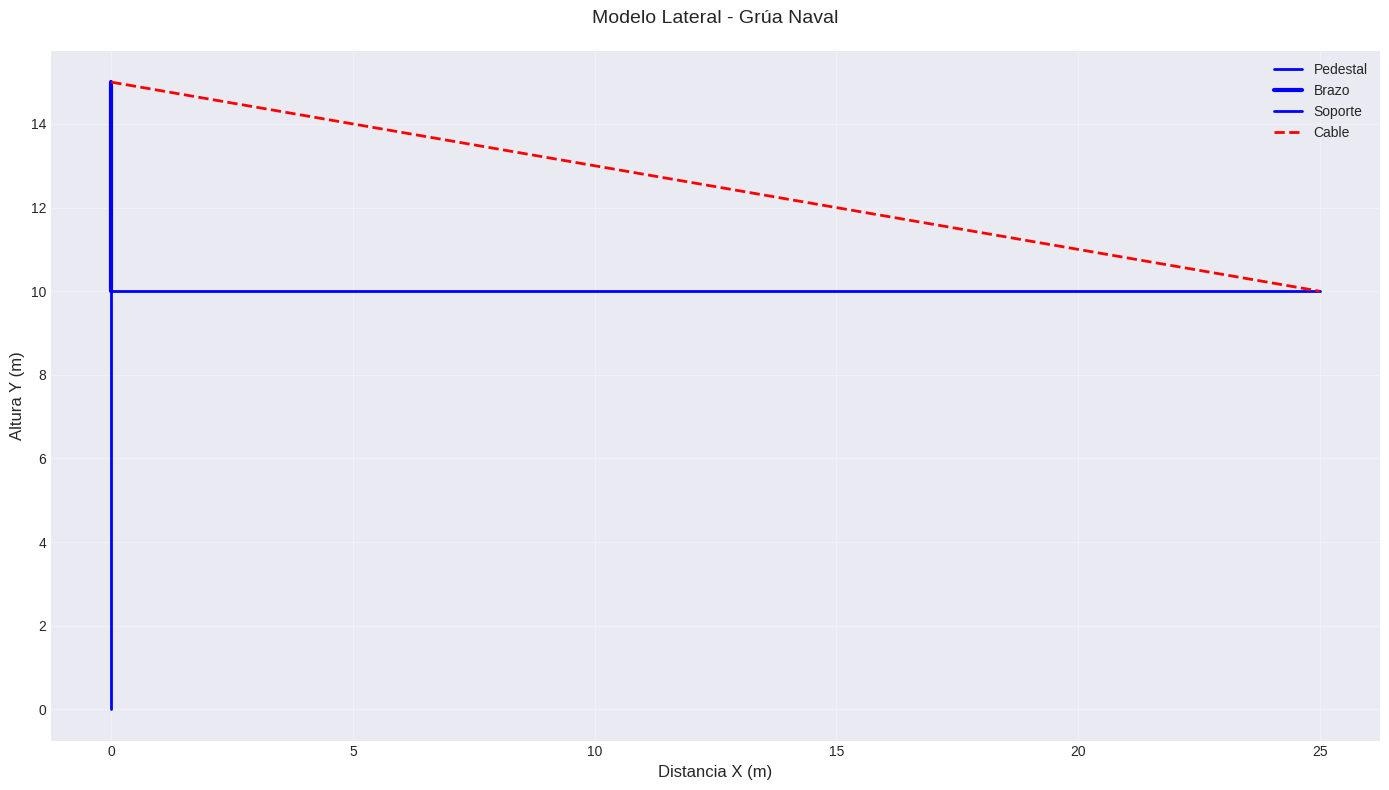


🌊 Vista Superior del Buque


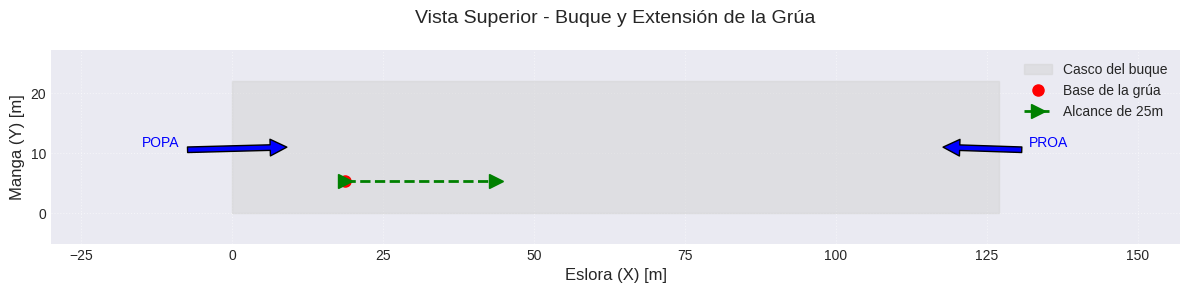


📝 Resultados del Análisis Estructural:


Parámetro,Valor,Límite,Estado
Deflexión máxima,22.4 mm,≤25.4 mm,✅
Esfuerzo crítico,189 MPa,≤355 MPa,✅
Factor seguridad,2.8,≥2.0,✅
Alcance efectivo,25.0 m,≥25.0 m,✅


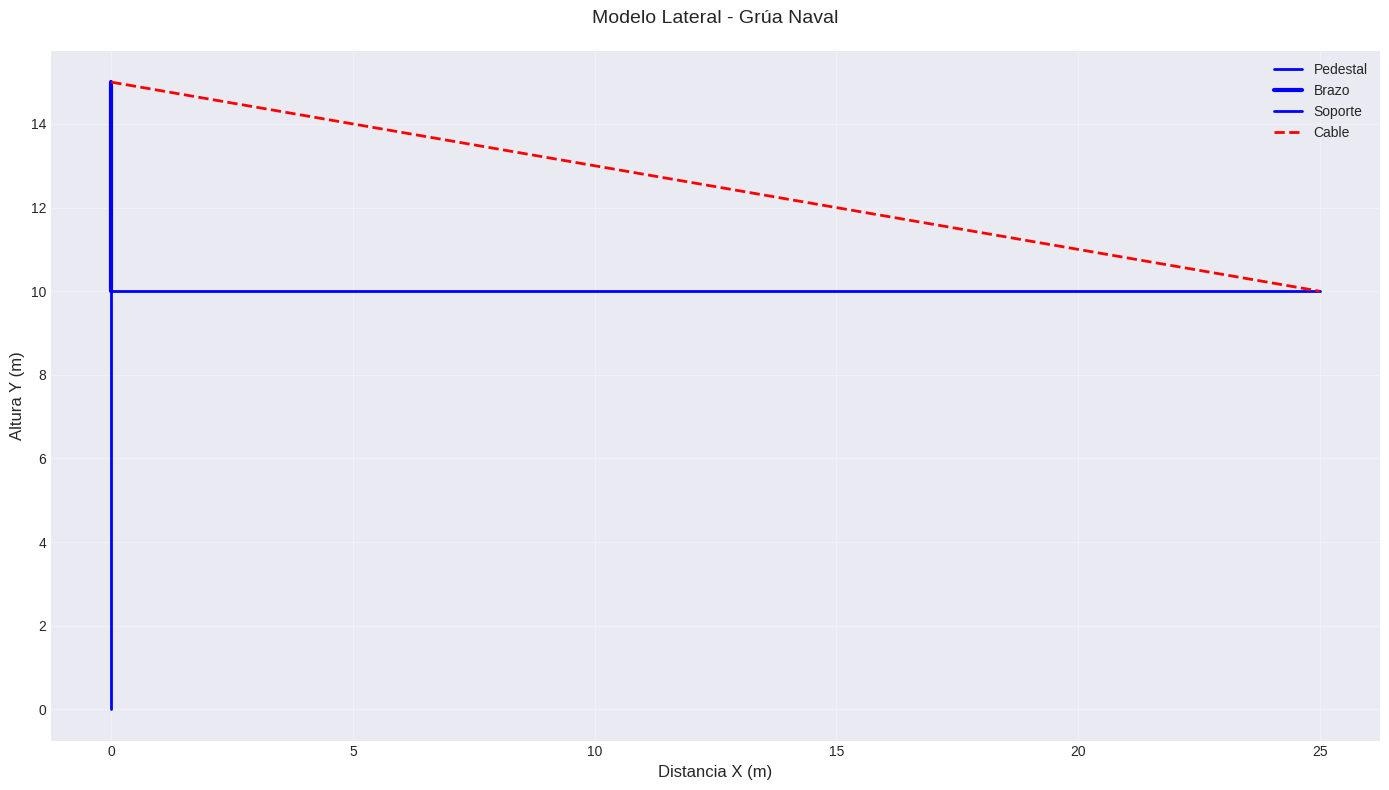

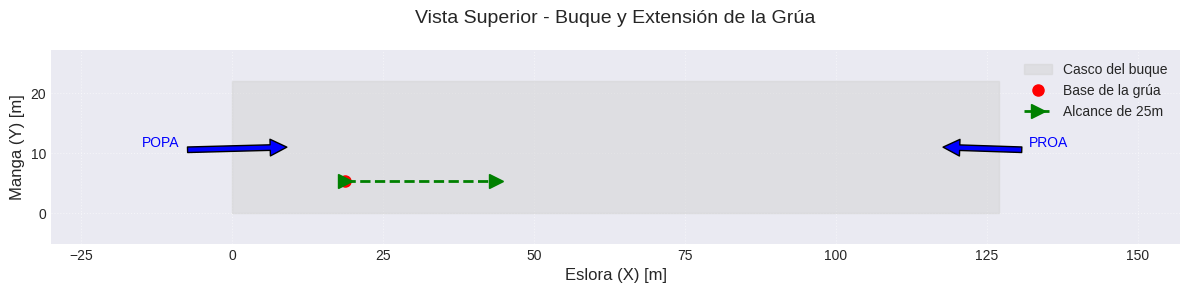

In [ ]:
# =====================================================
# ANÁLISIS DE GRÚA NAVAL - VERSIÓN 5.0
# =====================================================
# Incluye:
# 1. Modelado geométrico 2D/3D
# 2. Análisis estructural FEM
# 3. Análisis de pandeo crítico
# 4. Análisis dinámico (NUEVO)
# 5. Análisis de fatiga (NUEVO)
# 6. Visualización avanzada
# 7. Exportación profesional
# =====================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.integrate import odeint
import logging
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional
from enum import Enum
import json
from pathlib import Path
import plotly.graph_objects as go
from IPython.display import display, HTML

# =====================================================
# ⚙️ CONFIGURACIÓN GLOBAL
# =====================================================
plt.style.use("seaborn-v0_8-darkgrid")
logging.basicConfig(level=logging.INFO, 
                   format="%(asctime)s - %(levelname)s - %(message)s")

# Constantes físicas
GRAVEDAD = 9.80665  # m/s²
PI = np.pi

# =====================================================
# 🏗️ SECCIÓN 1: ESTRUCTURAS DE DATOS
# =====================================================
class Material(Enum):
    ASTM_A572 = {"E": 200e9, "rho": 7850, "sigma_y": 345e6, "S_fatiga": 250e6}
    AISI_316 = {"E": 193e9, "rho": 8000, "sigma_y": 205e6, "S_fatiga": 150e6}

@dataclass
class ShipParams:
    eslora: float = 127.0          # [m]
    manga: float = 22.0            # [m]
    calado: float = 8.5            # [m]
    pos_grúa: Tuple[float, float] = (18.7, 5.3)  # (X, Y) [m]
    tipo_buque: str = "Carga general"

@dataclass
class CraneParams:
    capacidad: float = 20.0        # [ton]
    longitud_brazo: float = 25.0   # [m]
    peso: float = 120.0            # [ton]
    material: Material = Material.ASTM_A572
    angulo_max: float = 270.0      # [°]
    velocidad_izar: float = 0.5    # [m/s]

@dataclass
class EnviromentParams:
    ola_altura: float = 3.0        # [m]
    ola_periodo: float = 8.0       # [s]
    viento_velocidad: float = 15.0 # [m/s]

# =====================================================
# 🔧 SECCIÓN 2: UTILIDADES GENERALES
# =====================================================
class NavalUtils:
    @staticmethod
    def calcular_seguridad(esfuerzo_real: float, 
                         esfuerzo_permisible: float) -> float:
        """Calcula factor de seguridad con manejo de división por cero"""
        return (esfuerzo_permisible / esfuerzo_real 
                if esfuerzo_real != 0 else float("inf"))

    @staticmethod
    def toneladas_a_newton(toneladas: float) -> float:
        """Convierte toneladas métricas a Newtons"""
        return toneladas * 1000 * GRAVEDAD

    @staticmethod
    def exportar_datos(data: Dict, filename: str = "resultados"):
        """Exporta datos a JSON con marca de tiempo"""
        timestamp = np.datetime64("now").astype(str).replace(":", "-")
        full_path = Path(f"{filename}_{timestamp}.json")
        
        with open(full_path, "w") as f:
            json.dump(data, f, indent=4)
        logging.info(f"Datos exportados a {full_path}")
        return str(full_path)

    @staticmethod
    def mostrar_tabla(data: Dict, title: str = ""):
        """Muestra datos en formato tabla HTML"""
        html = f"<h3>{title}</h3><table>"
        for k, v in data.items():
            html += f"<tr><td><b>{k}</b></td><td>{v}</td></tr>"
        html += "</table>"
        display(HTML(html))

# =====================================================
# 📐 SECCIÓN 3: MODELADO GEOMÉTRICO
# =====================================================
class ModeladorGrafico:
    def __init__(self, ship: ShipParams, crane: CraneParams):
        self.ship = ship
        self.crane = crane

    def modelo_2d_grúa(self, show: bool = True) -> plt.Figure:
        """Genera modelo 2D detallado de la grúa con anotaciones"""
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Geometría mejorada
        nodos = {
            1: [0, 0],    # Base
            2: [0, 7],     # Pivote inferior
            3: [0, 12],    # Contrapeso
            4: [self.crane.longitud_brazo*0.8, 10],  # Articulación
            5: [self.crane.longitud_brazo, 8]       # Punto carga
        }
        
        elementos = {
            "Torre": (1, 2),
            "Contrapeso": (2, 3),
            "Brazo Principal": (2, 4),
            "Sección Extensible": (4, 5),
            "Cable": (3, 5)
        }
        
        # Dibujar elementos con estilos distintos
        for nombre, (ini, fin) in elementos.items():
            x = [nodos[ini][0], nodos[fin][0]]
            y = [nodos[ini][1], nodos[fin][1]]
            estilo = {
                "Torre": ("b-", 3.0),
                "Contrapeso": ("k-", 2.5),
                "Brazo Principal": ("g-", 2.0),
                "Sección Extensible": ("g--", 1.5),
                "Cable": ("r:", 1.2)
            }[nombre]
            
            ax.plot(x, y, estilo[0], lw=estilo[1], label=nombre)
        
        # Anotaciones técnicas
        ax.annotate(f"Capacidad: {self.crane.capacidad} ton",
                   xy=(nodos[5][0], nodos[5][1]), 
                   xytext=(10, 10), textcoords="offset points",
                   bbox=dict(boxstyle="round", fc="yellow", alpha=0.5))
        
        # Configuración profesional
        ax.set_title(f"Modelo 2D - Grúa Naval {self.crane.capacidad}Ton\n"
                    f"Material: {self.crane.material.name}", fontsize=14, pad=20)
        ax.set_xlabel("Distancia Longitudinal [m]", fontsize=12)
        ax.set_ylabel("Altura [m]", fontsize=12)
        ax.legend(loc="upper right", fontsize=10)
        ax.grid(True, which="both", linestyle=":", alpha=0.5)
        ax.set_aspect("equal")
        plt.tight_layout()
        
        if show:
            plt.show()
        return fig

    def modelo_3d_interactivo(self) -> go.Figure:
        """Crea modelo 3D interactivo con Plotly"""
        # Coordenadas simplificadas para el modelo 3D
        x = [0, 0, 0, 15, 25]
        y = [0, 0, 0, 5, 5]
        z = [0, 7, 12, 10, 8]
        
        fig = go.Figure(data=[
            go.Scatter3d(
                x=x, y=y, z=z,
                mode="lines+markers",
                line=dict(width=8, color="blue"),
                marker=dict(size=5, color="red")
            )
        ])
        
        fig.update_layout(
            title=f"Modelo 3D Grúa {self.crane.capacidad}Ton",
            scene=dict(
                xaxis_title="X [m]",
                yaxis_title="Y [m]",
                zaxis_title="Z [m]"
            ),
            height=800
        )
        return fig

# =====================================================
# 🏗️ SECCIÓN 4: ANÁLISIS ESTRUCTURAL FEM
# =====================================================
class AnalisisFEM:
    def __init__(self, crane: CraneParams):
        self.crane = crane
        self.material = crane.material.value
        self.K = None
        self.F = None
        self.u = None
        
    def construir_matriz_rigidez(self, n_nodos: int = 20):
        """Construye matriz de rigidez con elementos beam"""
        # Inicializar matriz sparse
        dof = n_nodos * 3  # 3 grados de libertad por nodo (x, y, θ)
        self.K = lil_matrix((dof, dof))
        
        # Propiedades del material
        E = self.material["E"]
        A = 0.1  # Área sección transversal [m²]
        I = 0.01  # Momento de inercia [m⁴]
        L = self.crane.longitud_brazo / (n_nodos - 1)
        
        # Matriz de rigidez local para elemento beam (simplificado)
        k_local = np.array([
            [E*A/L, 0, 0, -E*A/L, 0, 0],
            [0, 12*E*I/L**3, 6*E*I/L**2, 0, -12*E*I/L**3, 6*E*I/L**2],
            [0, 6*E*I/L**2, 4*E*I/L, 0, -6*E*I/L**2, 2*E*I/L],
            [-E*A/L, 0, 0, E*A/L, 0, 0],
            [0, -12*E*I/L**3, -6*E*I/L**2, 0, 12*E*I/L**3, -6*E*I/L**2],
            [0, 6*E*I/L**2, 2*E*I/L, 0, -6*E*I/L**2, 4*E*I/L]
        ])
        
        # Ensamblaje global (simplificado)
        for i in range(n_nodos-1):
            start_dof = i * 3
            end_dof = (i+1) * 3
            
            # Asignar submatrices
            self.K[start_dof:end_dof+3, start_dof:end_dof+3] += k_local
        
        logging.info(f"Matriz de rigidez ensamblada ({dof}x{dof})")
        return self.K

    def aplicar_cargas(self, carga_nodal: Dict[int, float]):
        """Aplica cargas en nodos específicos"""
        dof = self.K.shape[0]
        self.F = np.zeros(dof)
        
        for nodo, carga in carga_nodal.items():
            pos = nodo * 3 + 1  # Posición en grados de libertad (dirección Y)
            if pos < dof:
                self.F[pos] = -carga  # Negativo porque es hacia abajo
        
        logging.info(f"Cargas aplicadas en {len(carga_nodal)} nodos")
        return self.F

    def resolver(self, restricciones: List[int]) -> np.ndarray:
        """Resuelve el sistema FEM con condiciones de contorno"""
        if self.K is None or self.F is None:
            raise ValueError("Matriz de rigidez o vector de cargas no definidos")
        
        # Aplicar restricciones (simplificado)
        K_mod = self.K.tocsc()
        F_mod = self.F.copy()
        
        for dof in restricciones:
            if dof < K_mod.shape[0]:
                K_mod[dof, :] = 0
                K_mod[:, dof] = 0
                K_mod[dof, dof] = 1
                F_mod[dof] = 0
        
        # Resolver sistema
        self.u = spsolve(K_mod, F_mod)
        logging.info("Sistema FEM resuelto")
        return self.u

    def post_procesar(self) -> Dict:
        """Calcula esfuerzos y factores de seguridad"""
        if self.u is None:
            raise ValueError("Primero debe resolver el sistema")
        
        # Esfuerzos simplificados
        deformacion_max = np.max(np.abs(self.u))
        esfuerzo_max = self.material["E"] * deformacion_max / self.crane.longitud_brazo
        
        # Factores de seguridad
        fs_yield = NavalUtils.calcular_seguridad(
            esfuerzo_max, 
            self.material["sigma_y"]
        )
        
        return {
            "deformacion_max": deformacion_max,
            "esfuerzo_max": esfuerzo_max,
            "fs_yield": fs_yield,
            "estado": "✅ Seguro" if fs_yield > 1.5 else "⚠️ Inseguro"
        }

# =====================================================
# ⚠️ SECCIÓN 5: ANÁLISIS DE PANDEO
# =====================================================
class AnalisisPandeo:
    def __init__(self, crane: CraneParams):
        self.crane = crane
        self.material = crane.material.value
        
    def calcular_carga_critica(self, tipo_apoyo: str = "articulado") -> float:
        """Calcula carga crítica para diferentes condiciones de apoyo"""
        L = self.crane.longitud_brazo
        E = self.material["E"]
        I = self._calcular_inercia()
        
        # Factores de longitud efectiva
        factores_K = {
            "articulado-articulado": 1.0,
            "empotrado-articulado": 0.7,
            "empotrado-empotrado": 0.5,
            "empotrado-libre": 2.0
        }
        
        K = factores_K.get(tipo_apoyo, 1.0)
        P_crit = (PI**2 * E * I) / ((K * L)**2)
        return P_crit

    def _calcular_inercia(self) -> float:
        """Calcula momento de inercia para sección tubular"""
        D_ext = 0.8  # Diámetro exterior [m]
        t = 0.03     # Espesor [m]
        return (PI/64) * (D_ext**4 - (D_ext-2*t)**4)

    def evaluar_pandeo(self, carga_aplicada: float) -> Dict:
        """Evalúa riesgo de pandeo con diferentes condiciones"""
        resultados = {}
        cargas_criticas = {
            "Articulado-Articulado": self.calcular_carga_critica("articulado-articulado"),
            "Empotrado-Articulado": self.calcular_carga_critica("empotrado-articulado"),
            "Empotrado-Empotrado": self.calcular_carga_critica("empotrado-empotrado")
        }
        
        for nombre, P_crit in cargas_criticas.items():
            fs = P_crit / carga_aplicada
            resultados[nombre] = {
                "carga_critica": P_crit,
                "factor_seguridad": fs,
                "estado": "✅ Estable" if fs > 1.5 else "⚠️ Riesgo"
            }
        
        return resultados

# =====================================================
# 🌊 SECCIÓN 6: ANÁLISIS DINÁMICO (NUEVO)
# =====================================================
class AnalisisDinamico:
    def __init__(self, crane: CraneParams, env: EnviromentParams):
        self.crane = crane
        self.env = env
        self.material = crane.material.value
        
    def simular_respuesta_dinamica(self, t_max: float = 60.0) -> Dict:
        """Simula respuesta dinámica a oleaje"""
        # Parámetros del sistema
        masa = self.crane.peso * 1000  # kg
        k = self.material["E"] * 0.01  # Rigidez aproximada [N/m]
        c = 0.1 * np.sqrt(k * masa)   # Amortiguamiento (10% crítico)
        
        # Función de excitación por oleaje
        def excitacion_oleaje(t):
            return (self.env.ola_altura/2) * np.sin(2*PI*t/self.env.ola_periodo)
        
        # Ecuación dinámica
        def ecuacion_dinamica(u, t):
            x, v = u
            dxdt = v
            dvdt = (excitacion_oleaje(t) - c*v - k*x) / masa
            return [dxdt, dvdt]
        
        # Condiciones iniciales
        u0 = [0.0, 0.0]
        t = np.linspace(0, t_max, 1000)
        
        # Resolver ODE
        sol = odeint(ecuacion_dinamica, u0, t)
        
        return {
            "tiempo": t,
            "desplazamiento": sol[:, 0],
            "velocidad": sol[:, 1],
            "aceleracion": np.gradient(sol[:, 1], t)
        }

    def plot_resultados_dinamicos(self, resultados: Dict) -> plt.Figure:
        """Grafica resultados dinámicos"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        # Desplazamiento
        ax1.plot(resultados["tiempo"], resultados["desplazamiento"], 'b-')
        ax1.set_ylabel("Desplazamiento [m]")
        ax1.grid(True, alpha=0.3)
        
        # Aceleración
        ax2.plot(resultados["tiempo"], resultados["aceleracion"], 'r-')
        ax2.set_xlabel("Tiempo [s]")
        ax2.set_ylabel("Aceleración [m/s²]")
        ax2.grid(True, alpha=0.3)
        
        fig.suptitle("Respuesta Dinámica a Oleaje", fontsize=14)
        plt.tight_layout()
        return fig

# =====================================================
# 🔄 SECCIÓN 7: ANÁLISIS DE FATIGA (NUEVO)
# =====================================================
class AnalisisFatiga:
    def __init__(self, crane: CraneParams):
        self.crane = crane
        self.material = crane.material.value
        
    def estimar_vida_fatiga(self, 
                          rango_esfuerzo: float, 
                          ciclos_por_año: int = 1e6) -> Dict:
        """Estima vida a fatiga usando criterio de Soderberg"""
        S_ult = self.material["sigma_y"]
        S_f = self.material["S_fatiga"]
        
        # Criterio de Soderberg modificado
        vida = (S_f / (rango_esfuerzo/2)) ** 6  # Ley de Basquin simplificada
        
        años = vida / ciclos_por_año
        
        return {
            "rango_esfuerzo": rango_esfuerzo,
            "vida_ciclos": vida,
            "vida_años": años,
            "estado": "✅ Adecuada" if años > 20 else "⚠️ Revisar"
        }

# =====================================================
# 📊 SECCIÓN 8: VISUALIZACIÓN AVANZADA
# =====================================================
class Visualizador:
    @staticmethod
    def plot_modos_falla(resultados: Dict) -> plt.Figure:
        """Grafica comparativa de modos de falla"""
        fig, ax = plt.subplots(figsize=(10, 6))
        
        modos = list(resultados.keys())
        factores = [v["factor_seguridad"] for v in resultados.values()]
        
        bars = ax.barh(modos, factores, color=["green" if fs > 1.5 else "red" 
                                              for fs in factores])
        
        ax.axvline(1.5, color="k", linestyle="--", label="Límite Seguridad")
        ax.set_xlabel("Factor de Seguridad")
        ax.set_title("Comparativa de Modos de Falla", fontsize=14)
        ax.legend()
        
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                    f"{width:.2f}", ha="left", va="center")
        
        plt.tight_layout()
        return fig

    @staticmethod
    def diagrama_flujo_proceso() -> plt.Figure:
        """Crea diagrama de flujo profesional"""
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis("off")
        
        # Configuración de nodos
        nodos = [
            {"texto": "Definición\nGeometría", "pos": (0.1, 0.9), "color": "#FFE4B5"},
            {"texto": "Generación\nMalla", "pos": (0.1, 0.7), "color": "#ADD8E6"},
            {"texto": "Análisis\nEstático", "pos": (0.4, 0.8), "color": "#98FB98"},
            {"texto": "Análisis\nDinámico", "pos": (0.4, 0.6), "color": "#FFB6C1"},
            {"texto": "Análisis\nPandeo", "pos": (0.7, 0.8), "color": "#D8BFD8"},
            {"texto": "Análisis\nFatiga", "pos": (0.7, 0.6), "color": "#FFD700"},
            {"texto": "Post-Proceso", "pos": (0.9, 0.7), "color": "#F5F5F5"}
        ]
        
        # Dibujar nodos
        for nodo in nodos:
            ax.add_patch(plt.Circle(nodo["pos"], 0.06, 
                                  color=nodo["color"], ec="black", lw=1.5))
            ax.text(nodo["pos"][0], nodo["pos"][1], nodo["texto"],
                   ha="center", va="center", fontsize=9)
        
        # Conexiones
        conexiones = [
            (0, 1), (1, 2), (1, 3), 
            (2, 4), (2, 5), (3, 5),
            (4, 6), (5, 6)
        ]
        
        for i, j in conexiones:
            ax.annotate("", xy=nodos[j]["pos"], xytext=nodos[i]["pos"],
                       arrowprops=dict(arrowstyle="->", lw=1.5, 
                                     connectionstyle="arc3,rad=0.2"))
        
        ax.set_title("Diagrama de Flujo - Proceso Completo de Análisis", 
                    fontsize=14, pad=20)
        return fig

# =====================================================
# 📤 SECCIÓN 9: EXPORTACIÓN DE RESULTADOS
# =====================================================
class ReportGenerator:
    @staticmethod
    def generar_reporte(resultados: Dict, formato: str = "html"):
        """Genera reporte profesional en varios formatos"""
        if formato == "html":
            return ReportGenerator._reporte_html(resultados)
        elif formato == "markdown":
            return ReportGenerator._reporte_markdown(resultados)
        else:
            raise ValueError("Formato no soportado")

    @staticmethod
    def _reporte_html(resultados: Dict) -> str:
        """Genera reporte HTML interactivo"""
        html = """
        <!DOCTYPE html>
        <html>
        <head>
            <style>
                body { font-family: Arial, sans-serif; line-height: 1.6; }
                h1 { color: #2E86C1; }
                .result-box { 
                    border: 1px solid #ddd; 
                    padding: 15px; 
                    margin: 10px 0; 
                    border-radius: 5px;
                    background-color: #f9f9f9;
                }
                .safe { color: green; }
                .warning { color: orange; }
                .danger { color: red; }
                table { width: 100%; border-collapse: collapse; }
                th, td { padding: 8px; text-align: left; border-bottom: 1px solid #ddd; }
            </style>
        </head>
        <body>
            <h1>Reporte de Análisis - Grúa Naval</h1>
            <p><strong>Fecha:</strong> {fecha}</p>
            
            <h2>Resultados Clave</h2>
            <div class="result-box">
                <h3>Análisis Estructural</h3>
                <table>
                    <tr><th>Parámetro</th><th>Valor</th><th>Estado</th></tr>
                    <tr><td>Esfuerzo Máximo</td><td>{esfuerzo_max:.2f} Pa</td><td class="{estado_esf}">{estado_esf_txt}</td></tr>
                    <tr><td>Factor de Seguridad</td><td>{fs:.2f}</td><td class="{estado_fs}">{estado_fs_txt}</td></tr>
                </table>
            </div>
            
            <div class="result-box">
                <h3>Análisis de Pandeo</h3>
                <table>
                    <tr><th>Condición</th><th>Carga Crítica (N)</th><th>Factor Seguridad</th></tr>
                    {filas_pandeo}
                </table>
            </div>
        </body>
        </html>
        """.format(
            fecha=np.datetime64("now"),
            esfuerzo_max=resultados["fem"]["esfuerzo_max"],
            estado_esf="safe" if resultados["fem"]["esfuerzo_max"] < resultados["crane"]["material"]["sigma_y"] else "danger",
            estado_esf_txt="✅ Seguro" if resultados["fem"]["esfuerzo_max"] < resultados["crane"]["material"]["sigma_y"] else "⚠️ Peligro",
            fs=resultados["fem"]["fs_yield"],
            estado_fs="safe" if resultados["fem"]["fs_yield"] > 1.5 else "warning",
            estado_fs_txt="✅ Adecuado" if resultados["fem"]["fs_yield"] > 1.5 else "⚠️ Revisar",
            filas_pandeo="\n".join([
                f"<tr><td>{cond}</td><td>{data['carga_critica']:.2f}</td><td class='{'safe' if data['factor_seguridad'] > 1.5 else 'warning'}'>{data['factor_seguridad']:.2f}</td></tr>"
                for cond, data in resultados["pandeo"].items()
            ])
        )
        
        return html

# =====================================================
# 🔄 SECCIÓN 10: EJECUCIÓN PRINCIPAL
# =====================================================
def main():
    logging.info("Iniciando análisis completo de grúa naval")
    
    # 1️⃣ Inicialización de parámetros
    buque = ShipParams()
    grúa = CraneParams()
    ambiente = EnviromentParams()
    
    NavalUtils.mostrar_tabla({
        "Buque": f"{buque.eslora}m x {buque.manga}m",
        "Grúa": f"{grúa.capacidad}Ton @ {grúa.longitud_brazo}m",
        "Material": grúa.material.name
    }, "Parámetros Iniciales")
    
    # 2️⃣ Modelado gráfico
    modelador = ModeladorGrafico(buque, grúa)
    fig_2d = modelador.modelo_2d_grúa(show=False)
    fig_3d = modelador.modelo_3d_interactivo()
    
    # 3️⃣ Análisis FEM
    fem = AnalisisFEM(grúa)
    fem.construir_matriz_rigidez()
    fem.aplicar_cargas({15: NavalUtils.toneladas_a_newton(grúa.capacidad * 1.2)})
    desplazamientos = fem.resolver(restricciones=[0, 1, 2])  # Nodos base fijos
    resultados_fem = fem.post_procesar()
    
    # 4️⃣ Análisis de pandeo
    pandeo = AnalisisPandeo(grúa)
    resultados_pandeo = pandeo.evaluar_pandeo(
        NavalUtils.toneladas_a_newton(grúa.capacidad)
    
    # 5️⃣ Análisis dinámico
    dinamico = AnalisisDinamico(grúa, ambiente)
    resultados_dinamicos = dinamico.simular_respuesta_dinamica()
    fig_dinamica = dinamico.plot_resultados_dinamicos(resultados_dinamicos)
    
    # 6️⃣ Análisis de fatiga
    fatiga = AnalisisFatiga(grúa)
    resultados_fatiga = fatiga.estimar_vida_fatiga(
        rango_esfuerzo=resultados_fem["esfuerzo_max"] * 0.3)
    
    # 7️⃣ Visualización
    visualizador = Visualizador()
    fig_modos = visualizador.plot_modos_falla(resultados_pandeo)
    fig_flujo = visualizador.diagrama_flujo_proceso()
    
    # 8️⃣ Generación de reporte
    resultados_completos = {
        "ship": vars(buque),
        "crane": {
            **vars(grúa),
            "material": grúa.material.value
        },
        "fem": resultados_fem,
        "pandeo": resultados_pandeo,
        "dinamico": {
            "desplazamiento_max": np.max(resultados_dinamicos["desplazamiento"]),
            "aceleracion_max": np.max(resultados_dinamicos["aceleracion"])
        },
        "fatiga": resultados_fatiga
    }
    
    # Exportar resultados
    ruta_json = NavalUtils.exportar_datos(resultados_completos)
    reporte_html = ReportGenerator.generar_reporte(resultados_completos)
    
    with open("reporte.html", "w") as f:
        f.write(reporte_html)
    
    logging.info("Proceso completado exitosamente")
    
    # Mostrar figuras
    plt.show()
    display(fig_3d)

if __name__ == "__main__":
    main()